### LSTM and Attention

We will build a more advanced model that explicitly accounts for dependencies between the events in a journey. This problem can be framed as a conversion prediction based on the ordered sequence of events, and recurrent neural networks (RNNs) are a common solution for it. We choose to use a basic long short-term memory (LSTM) architecture with 64 hidden units. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#df_Criteo_Attribution = pd.read_csv(r'/content/Criteo_Attribution_data.csv', engine='python')

data_file = '/content/drive/My Drive/Digital Marketing/Attribution Data/criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(data_file, sep='\t', compression='gzip')

In [4]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


## Data Pre-Processing 


In [0]:
n_campaigns = 400

In [0]:
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)

In [0]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [0]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

In [9]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072,0,20073966_-1,0.000000e+00,0.000000
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111,0,24607497_-1,7.487274e-07,0.163526
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072,0,25357769_-1,1.123091e-06,0.000000


In [0]:
np.random.seed(42)
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


In [0]:
df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

In [12]:
df_Criteo_Attribution.shape

(9889488, 26)

In [0]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [0]:
df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)

In [15]:
df_Criteo_Attribution.shape

(7405691, 26)

In [0]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [0]:
df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

In [18]:
df_Criteo_Attribution.shape

(579774, 26)

In [0]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [0]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

In [21]:
df_Criteo_Attribution.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [0]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [23]:
df_Criteo_Attribution.shape

(579774, 28)

In [24]:
[df_Criteo_Attribution[df_Criteo_Attribution.conversion == 0].shape[0], df_Criteo_Attribution[df_Criteo_Attribution.conversion == 1].shape[0]]

[290278, 289496]

In [25]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
65528,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
387213,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
401488,4,93907,17686799,0,-1,-1,0,1,-1,-1,0.000186,0.267100,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108,0,93907_-1,1.497455e-06,0.101299,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14394,4,19923387,31772643,0,-1,-1,0,0,-1,-1,0.000035,0.087070,179666,30763035,9312274,5028397,29196072,32440044,32440041,14074087,29196072,21091108,0,19923387_-1,1.497455e-06,0.069316,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
473426,4,28451570,20843295,0,-1,-1,0,0,-1,-1,0.000035,0.336611,-1,138937,9312274,15403272,29196072,32440042,28928366,8556462,29196072,29196072,0,28451570_-1,1.497455e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## LSTM(Long Short Term Memory)


In [26]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])
    
    x3d = []
    y = []
    for xi in x3d_list:
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi)
        journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        n_touchpoints = len(journey_matrix)
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y

x, y = features_for_lstm(df_Criteo_Attribution, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)


(125836, 15, 404)


In [27]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 80534 samples, validate on 20134 samples
Epoch 1/5





80534/80534 [==============================] - 38s 472us/step - loss: 0.3509 - acc: 0.8427 - val_loss: 0.2821 - val_acc: 0.8845
Epoch 2/5
80534/80534 [==============================] - 37s 459us/step - loss: 0.2948 - acc: 0.8722 - val_loss: 0.2517 - val_acc: 0.8972
Epoch 3/5
80534/80534 [==============================] - 39s 487us/step - loss: 0.2686 - acc: 0.8854 - val_loss: 0.2527 - val_acc: 0.9022
Epoch 4/5
80534/80534 [==============================] - 38s 474us/step - loss: 0.2562 - acc: 0.8919 - val_loss: 0.2454 - val_acc: 0.9008
Epoch 5/5
80534/80534 [==============================] - 37s 462us/step - loss: 0.2491 - acc: 0.8956 - val_loss: 0.2290 - val_acc: 0.9059
Test score: 0.2268214542975262
Test a

We can see that the LSTM approach provided significantly better accuracy compared with the logistic regression baseline. However, LSTM does not provide a simple way to extract the attribution weights from the fitted model. We can build a much better model on top of LSTM that provides both better accuracy and explicit estimates of attribution weights. 


### LSTM with Attention

In [28]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

main_output = Dense(1, activation='sigmoid')(weighted_activations)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 80534 samples, validate on 20134 samples
Epoch 1/5
80534/80534 [==============================] - 48s 594us/step - loss: 0.2536 - acc: 0.8919 - val_loss: 0.2257 - val_acc: 0.9038
Epoch 2/5
80534/80534 [==============================] - 47s 578us/step - loss: 0.2182 - acc: 0.9076 - val_loss: 0.2196 - val_acc: 0.9071
Epoch 3/5
80534/80534 [==============================] - 46s 572us/step - loss: 0.2109 - acc: 0.9111 - val_loss: 0.2175 - val_acc: 0.9092
Epoch 4/5
80534/80534 [==============================] - 46s 571us/step - loss: 0.2074 - acc: 0.9133 - val_loss: 0.2184 - val_acc: 0.9081
Epoch 5/5
80534/80534 [==============================] - 48s 595us/step - loss: 0.2053 - acc: 0.9145 - val_loss: 0.2186 - val_acc: 0.9092
Test score: 0.21560122279683572
Test accuracy: 0.9088525111252383


We get the best Accuracy with LSTM Attention Mechanism

In [0]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

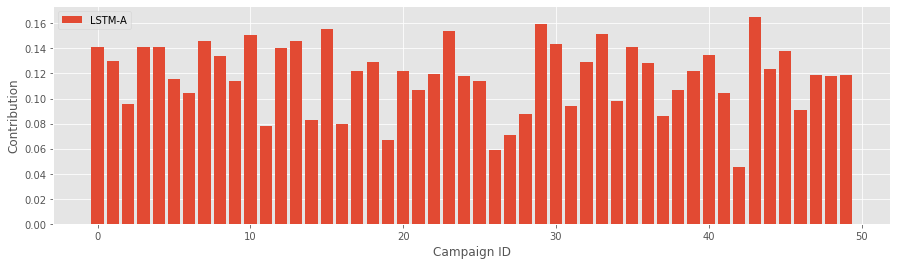

In [30]:
lstm_a = (attributions/campaign_freq)

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

In [0]:
np.savetxt("lstm_a.txt",lstm_a)